In [4]:
import os
import sys
sys.path.append("../NeuralTSNE/") # Comment out this line if you have NeuralTSNE installed.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import NeuralTSNE as ntsne

from torch.utils.data import TensorDataset, random_split
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import Trainer, seed_everything

torch.set_float32_matmul_precision("high")

%matplotlib inline

The dataset is alanine tetrapeptide in vaccum, available to download from https://zenodo.org/records/4756093 (`Data-ala3/ala3-vaccum-pt/Ala3-PT.repl0/colvar.0.data`. There are 12 features consisting of the sines and cosines of the dihedral angles. 

Detailed information about the dataset is described in *Multiscale Reweighted Stochastic Embedding (MRSE): Deep Learning of Collective Variables for Enhanced Sampling* (https://doi.org/10.1021/acs.jpca.1c02869).

In [5]:
!head -n 1 data/atp-feat-dih.data

#! FIELDS sin(phi-1) sin(psi-1) sin(phi-2) sin(psi-2) sin(phi-3) sin(psi-3) cos(phi-1) cos(psi-1) cos(phi-2) cos(psi-2) cos(phi-3) cos(psi-3)


In [7]:
X = np.loadtxt('data/atp-feat-dih.data')

In [8]:
X.shape

(100001, 12)

_Prepare the training and validation data._

The validation dataset will be 20% of the total number of samples.

In [9]:
X = torch.tensor(X, dtype=torch.float32)
dataset = TensorDataset(X)

valid = 0.2
n = len(dataset)
n_train = int((1.0 - valid) * n)
n_valid = n - n_train
train_dataset, valid_dataset = random_split(dataset, [n_train, n_valid])

_Initialize a neural network to perform dimensionality reduction._

The neural network will perform reduction from 12 to 2 dimensions.

In [10]:
multipliers = [0.75, 0.75, 0.75]
model = ntsne.TSNE.NeuralNetwork.NeuralNetwork(initial_features=12, n_components=2, multipliers=multipliers)

The neural networks with `multipliers` looks like this:

In [11]:
model

NeuralNetwork(
  (sequential_stack): Sequential(
    (0): Linear(in_features=12, out_features=9, bias=True)
    (ReLu0): ReLU()
    (1): Linear(in_features=9, out_features=9, bias=True)
    (ReLu1): ReLU()
    (2): Linear(in_features=9, out_features=9, bias=True)
    (ReLu2): ReLU()
    (3): Linear(in_features=9, out_features=2, bias=True)
  )
)

_Initialize parameters for tSNE._

We will train the neural network by minimizing the Kullback-Leibler divergence using perplexity of 30 and a batch size of 100.

In [ ]:
param_tsne = ntsne.TSNE.ParametricTSNE.ParametricTSNE(
    loss_fn="kl_divergence",
    perplexity=30,
    batch_size=1000,
    early_exaggeration_epochs=0,
    early_exaggeration_value=0,
    max_iterations=500,
    model=model
)

_Declare a `pytorch_lightning` trainer._

We will use a callback to perform early stopping, which works by terminating the learning if the validation loss reaches a required precision.

The results will be logged in `default_root_dir/lightning_logs` every 50 steps.

Seed is fixed for reproducibility.

In [ ]:
seed_everything(seed=42, workers=True)

early_stopping = EarlyStopping(monitor="val_loss", min_delta=1e-6, patience=10)

trainer = Trainer(
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    log_every_n_steps=50,
    max_epochs=param_tsne.max_iterations,
    callbacks=[early_stopping],
    default_root_dir=".",
    deterministic=True # seed
)

In [16]:
reducer = ntsne.TSNE.Modules.DimensionalityReduction(
    tsne=param_tsne, 
    shuffle=False, 
    optimizer="adam", 
    lr=1e-3
)

_Prepare dataloaders with the training and validation data._

We also create a dataloader for the full dataset.

In [17]:
train_dataloader, _ = param_tsne.create_dataloaders(train_dataset, None)
valid_dataloader, _ = param_tsne.create_dataloaders(valid_dataset, None)

full_dataloader, _ = param_tsne.create_dataloaders(dataset, None)

_Train t-SNE._

A previous model can be loaded if it is available.

In [ ]:
model_name = "data/atp-model-dih.pt"
load_model = False

if load_model:
    param_tsne.read_model(model_name)

trainer.fit(reducer, train_dataloaders=train_dataloader, val_dataloaders=[valid_dataloader])

param_tsne.save_model(model_name)

_Evaluate the model on all available samples from the dataset._

In [ ]:
Z = trainer.predict(reducer, full_dataloader)
Z = np.concatenate(Z, axis=0)

_Save the mapped samples in reduced space._

In [20]:
np.savetxt("data/atp-colvar-dih.data", Z)

_Plot the results._

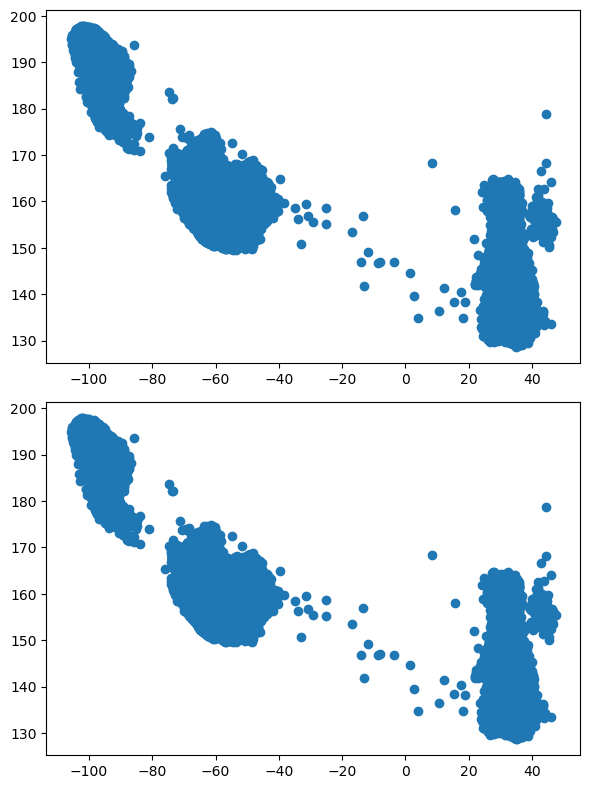

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

sctr = ax[0].scatter(Z[:,0], Z[:, 1])

sctr = ax[1].scatter(Z[:,0], Z[:, 1])

plt.tight_layout()

_Plot training curves from logged results._

In [27]:
run_number = 0

log = pd.read_csv("lightning_logs/version_" + str(run_number) + "/metrics.csv")

In [28]:
log

,epoch,step,train_loss,val_loss
0,0,79,NaN,3.183048
1,0,79,3.332674,NaN
2,1,159,NaN,2.180909
3,1,159,2.708722,NaN
4,2,239,NaN,1.807909
...,...,...,...,...
833,416,33359,0.858242,NaN
834,417,33439,NaN,0.859873
835,417,33439,0.858240,NaN
836,418,33519,NaN,0.859812


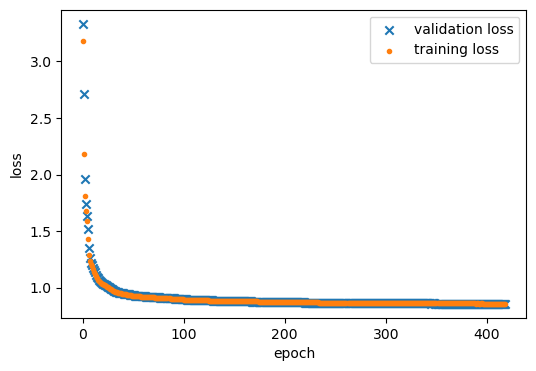

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.scatter(log['epoch'], log['train_loss'], label='validation loss', marker='x')
ax.scatter(log['epoch'], log['val_loss'], label='training loss', marker='.')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

plt.legend()